In [1]:
!pip install datasets -q

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import random
import numpy as np
from datasets import load_dataset
from sklearn.metrics import f1_score
from copy import deepcopy
import os

# Set a fixed random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class CustomHFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, test_flag=False):
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.test_flag = test_flag

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        example = self.hf_dataset[idx]
        image = example['image']
        label = example['label']
        if self.transform:
            image = self.transform(image)
        if self.test_flag:
            return image, example['idx']
        else:
            return image, label

# -------------------------------------------
# Load dataset
# -------------------------------------------
dataset = load_dataset('hmdliu/ACAC-4K')

# Compute mean and std of the training set
temp_transform = transforms.ToTensor()
temp_dataset = CustomHFDataset(dataset['train'], transform=temp_transform, test_flag=False)

def compute_mean_std(dset):
    loader = DataLoader(dset, batch_size=32, shuffle=False)
    mean = 0.0
    var = 0.0
    total_pixels = 0
    for imgs, _ in loader:
        # imgs: (B, C, H, W)
        imgs = imgs.view(imgs.size(0), imgs.size(1), -1)
        batch_pixels = imgs.size(0)*imgs.size(2)
        mean += imgs.sum(dim=[0,2])
        var += (imgs**2).sum(dim=[0,2])
        total_pixels += batch_pixels
    mean = mean / total_pixels
    var = var / total_pixels
    std = torch.sqrt(var - mean**2)
    return mean.tolist(), std.tolist()

mean, std = compute_mean_std(temp_dataset)

print("Computed mean:", mean)
print("Computed std:", std)

# -------------------------------------------
# Define transforms
# -------------------------------------------
base_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Stronger augmentations + Mixup or CutMix will be handled in training loop
train_augment = transforms.Compose([
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# -------------------------------------------
# Create base dataset and split train/val
# -------------------------------------------
train_dataset_raw = CustomHFDataset(dataset['train'], transform=base_transform, test_flag=False)
test_dataset = CustomHFDataset(dataset['test'], transform=val_transform, test_flag=True)

num_train = len(train_dataset_raw)
indices = list(range(num_train))
random.shuffle(indices)
val_ratio = 0.1
split = int(val_ratio * num_train)
val_indices = indices[:split]
train_indices = indices[split:]

val_dataset = Subset(train_dataset_raw, val_indices)

all_labels = [train_dataset_raw[i][1] for i in range(len(train_dataset_raw))]

Computed mean: [0.6204590201377869, 0.5430712699890137, 0.44747450947761536]
Computed std: [0.1726725846529007, 0.1666186898946762, 0.1685081124305725]


In [ ]:
# -------------------------------------------
# Stage 1: Binary AI vs Non-AI classification for initial label correction
# -------------------------------------------
ai_indices = [i for i, l in enumerate(all_labels) if l == 5]
non_ai_indices = [i for i, l in enumerate(all_labels) if l in [0,1,2,3,4]]

# Balance binary training set
sample_size = min(len(ai_indices), len(non_ai_indices))
random.shuffle(non_ai_indices)
balanced_non_ai_indices = non_ai_indices[:sample_size]
binary_train_indices = ai_indices + balanced_non_ai_indices
random.shuffle(binary_train_indices)

class BinaryAIDataset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        bin_label = 1 if label == 5 else 0
        return img, bin_label

binary_train_dataset = BinaryAIDataset(train_dataset_raw, binary_train_indices)
binary_train_loader = DataLoader(binary_train_dataset, batch_size=32, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# A stronger binary model, say a wider resnet (no pretrained)
binary_model = models.resnet50(pretrained=False)
binary_model.fc = nn.Linear(binary_model.fc.in_features, 2)
binary_model = binary_model.to(device)

criterion_bin = nn.CrossEntropyLoss()
optimizer_bin = optim.Adam(binary_model.parameters(), lr=1e-4)
epochs_bin = 15

binary_model.train()
for epoch in range(epochs_bin):
    total_loss = 0.0
    for imgs, lbs in binary_train_loader:
        imgs, lbs = imgs.to(device), lbs.to(device)
        optimizer_bin.zero_grad()
        logits = binary_model(imgs)
        loss = criterion_bin(logits, lbs)
        loss.backward()
        optimizer_bin.step()
        total_loss += loss.item()
    print(f"[Binary Model] Epoch {epoch+1}/{epochs_bin}, Loss: {total_loss/len(binary_train_loader):.4f}")

# Inference for AI probabilities
binary_model.eval()
ai_probs = []
with torch.no_grad():
    for i in range(len(train_dataset_raw)):
        img, lb = train_dataset_raw[i]
        img = img.unsqueeze(0).to(device)
        logit = binary_model(img)
        prob = F.softmax(logit, dim=1)[0,1].item()
        ai_probs.append(prob)

# Initial threshold-based correction
threshold = 0.5
corrected_labels = deepcopy(all_labels)
for i in range(len(corrected_labels)):
    if corrected_labels[i] != 5 and ai_probs[i] > threshold:
        corrected_labels[i] = 5

[Binary Model] Epoch 1/15, Loss: 0.4646
[Binary Model] Epoch 2/15, Loss: 0.3857
[Binary Model] Epoch 3/15, Loss: 0.3700
[Binary Model] Epoch 4/15, Loss: 0.3364
[Binary Model] Epoch 5/15, Loss: 0.3196
[Binary Model] Epoch 6/15, Loss: 0.3350
[Binary Model] Epoch 7/15, Loss: 0.3587
[Binary Model] Epoch 8/15, Loss: 0.3005
[Binary Model] Epoch 9/15, Loss: 0.2986
[Binary Model] Epoch 10/15, Loss: 0.2448
[Binary Model] Epoch 11/15, Loss: 0.2214
[Binary Model] Epoch 12/15, Loss: 0.2370
[Binary Model] Epoch 13/15, Loss: 0.2294
[Binary Model] Epoch 14/15, Loss: 0.1986
[Binary Model] Epoch 15/15, Loss: 0.2251


C:\Users\zhuol\AppData\Local\Temp\ipykernel_20784\182318939.py:131: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\zhuol\anaconda3\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\zhuol\AppData\Local\Temp\ipykernel_20784\182318939.py:179: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\zhuol\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


AssertionError: Wrong image height! Expected 224 but got 512!

In [ ]:
# -------------------------------------------
# Prepare the corrected dataset for the main classifier
# -------------------------------------------
class CorrectedDataset(Dataset):
    def __init__(self, hf_dataset, corrected_labels, transform=None):
        self.hf_dataset = hf_dataset
        self.corrected_labels = corrected_labels
        self.transform = transform
    def __len__(self):
        return len(self.hf_dataset)
    def __getitem__(self, idx):
        example = self.hf_dataset[idx]
        image = example['image']
        label = self.corrected_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
import pandas as pd
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler
import random
from copy import deepcopy
from sklearn.metrics import f1_score

In [8]:
import pandas as pd
import ast
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
from torchvision import transforms
from PIL import Image

In [11]:
df = pd.read_csv('cleaned_dataset_labels.csv')

# Extract 'idx' from the string using regex
df['idx'] = df['image_path'].str.extract(r"'idx':\s*(\d+)")
df['idx'] = df['idx'].astype(int)

# Now use idx_to_label without ast.literal_eval
idx_to_label = dict(zip(df['idx'], df['label']))

class ReLabeledDataset(Dataset):
    def __init__(self, original_dataset, idx_to_label):
        self.ds = original_dataset
        self.idx_to_label = idx_to_label

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, i):
        image, _ = self.ds[i]
        new_label = self.idx_to_label[i]
        return image, new_label

final_train_dataset = ReLabeledDataset(train_dataset_raw, idx_to_label)

# Continue with your train/val split and DataLoaders
train_ratio = 0.8
train_len = int(len(final_train_dataset) * train_ratio)
val_len = len(final_train_dataset) - train_len

train_dataset_split, val_dataset = random_split(
    final_train_dataset, [train_len, val_len],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset_split, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [28]:
train_augment = transforms.Compose([
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# -------------------------------------------
# Define a Vision Transformer model from scratch
# -------------------------------------------
vit_model = models.vit_b_16(weights=None,image_size=512)  # no pretrained weights
num_features = vit_model.heads[0].in_features
vit_model.heads[0] = nn.Linear(num_features,6)
vit_model.load_state_dict(torch.load("vit_model.pth", map_location=device))

vit_model = vit_model.to(device)

# Label smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    def forward(self, x, target):
        log_probs = F.log_softmax(x, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (x.size(-1) - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer = optim.AdamW(vit_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

scaler = torch.cuda.amp.GradScaler()

# Mixup function
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def evaluate(model, loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for img, lb in loader:
            img, lb = img.to(device), lb.to(device)
            out = model(img)
            pred = out.argmax(dim=1).cpu().numpy()
            preds.extend(pred)
            trues.extend(lb.cpu().numpy())
    preds = np.array(preds)
    trues = np.array(trues)
    accuracy = (preds == trues).mean()
    f1_scores = f1_score(trues, preds, labels=range(6), average=None, zero_division=0)
    f1_non_ai = np.mean(f1_scores[:5])
    f1_ai = f1_scores[5]
    weighted_metric = (accuracy + f1_non_ai + f1_ai) / 3
    return accuracy, f1_non_ai, f1_ai, weighted_metric

# -------------------------------------------
# Train final model (first round)
# -------------------------------------------
epochs = 5 #Ajust from 20 to 5 here
best_wm = 0.0
for epoch in range(epochs):
    vit_model.train()
    total_loss = 0
    for img, lb in train_loader:
        img, lb = img.to(device), lb.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            if random.random() < 0.5:
                # apply mixup
                img, y_a, y_b, lam = mixup_data(img, lb)
                logits = vit_model(img)
                loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
            else:
                logits = vit_model(img)
                loss = criterion(logits, lb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    scheduler.step()

    acc, f1_non_ai, f1_ai, wm = evaluate(vit_model, val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Acc: {acc:.4f}, "
          f"F1_non_AI: {f1_non_ai:.4f}, F1_AI: {f1_ai:.4f}, WM: {wm:.4f}")
    if wm > best_wm:
        best_wm = wm
        best_model_state = deepcopy(vit_model.state_dict())

# Reinitialize and train again (fresh model or re-use the improved model)
# Let's reuse the improved model weights to save time
vit_model.load_state_dict(best_model_state)
optimizer = optim.AdamW(vit_model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
best_wm = 0.0

for epoch in range(epochs):
    vit_model.train()
    total_loss = 0
    for img, lb in train_loader:
        img, lb = img.to(device), lb.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            if random.random() < 0.5:
                img, y_a, y_b, lam = mixup_data(img, lb)
                logits = vit_model(img)
                loss = mixup_criterion(criterion, logits, y_a, y_b, lam)
            else:
                logits = vit_model(img)
                loss = criterion(logits, lb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    scheduler.step()

    acc, f1_non_ai, f1_ai, wm = evaluate(vit_model, val_loader)
    print(f"[Refined] Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, "
          f"Acc: {acc:.4f}, F1_non_AI: {f1_non_ai:.4f}, F1_AI: {f1_ai:.4f}, WM: {wm:.4f}")
    if wm > best_wm:
        best_wm = wm
        best_model_state = deepcopy(vit_model.state_dict())

vit_model.load_state_dict(best_model_state)

# -------------------------------------------

C:\Users\zhuol\AppData\Local\Temp\ipykernel_37404\920592544.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load("vit_model.pth", map_loc

Epoch 1/5, Loss: 1.1426, Acc: 0.7328, F1_non_AI: 0.5925, F1_AI: 0.9558, WM: 0.7604


C:\Users\zhuol\AppData\Local\Temp\ipykernel_37404\920592544.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\zhuol\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 2/5, Loss: 1.1028, Acc: 0.7109, F1_non_AI: 0.5349, F1_AI: 0.9387, WM: 0.7282


C:\Users\zhuol\AppData\Local\Temp\ipykernel_37404\920592544.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
c:\Users\zhuol\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


C:\Users\zhuol\AppData\Local\Temp\ipykernel_19900\3846653072.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load("vit_model.pth", map_lo

Validation Accuracy: 0.86875
Confusion Matrix:
 [[  9   0   0   0   0   1]
 [  2 122   5   5   5   2]
 [  1   2  39   0   3   2]
 [  0   5   2  76  18   3]
 [  0   5   1  13 146   1]
 [  3   0   3   2   0 164]]


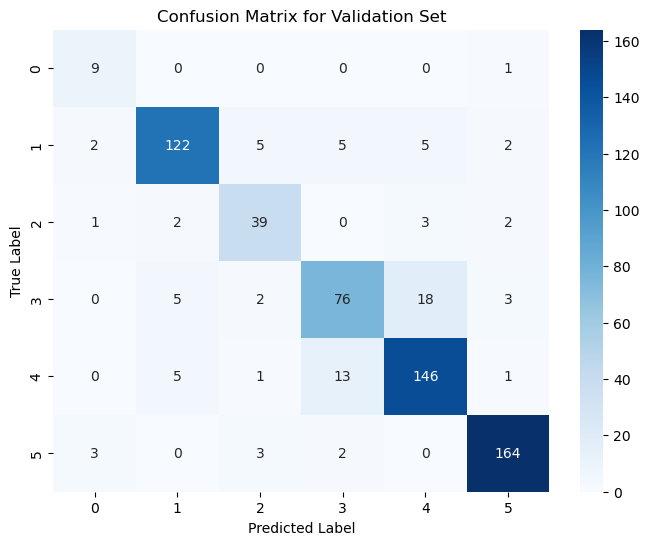

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
vit_model = models.vit_b_16(weights=None,image_size=512)  # no pretrained weights
num_features = vit_model.heads[0].in_features
vit_model.heads[0] = nn.Linear(num_features,6)
vit_model.load_state_dict(torch.load("vit_model.pth", map_location=device))
vit_model.eval()# Make sure the model is in evaluation mode

# Collect predictions and labels
all_preds = []
all_trues = []
with torch.no_grad():
    for img, lb in val_loader:
        img = img.to(device)
        lb = lb.to(device)
        outputs = vit_model(img)
        preds = outputs.argmax(dim=1).cpu().numpy()
        labels = lb.cpu().numpy()
        all_preds.extend(preds)
        all_trues.extend(labels)

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_trues = np.array(all_trues)

# Calculate confusion matrix
cm = confusion_matrix(all_trues, all_preds)
acc = accuracy_score(all_trues, all_preds)

print("Validation Accuracy:", acc)
print("Confusion Matrix:\n", cm)

# Optionally, you can visualize the confusion matrix:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set')
plt.show()

C:\Users\zhuol\AppData\Local\Temp\ipykernel_19900\791220323.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load("vit_model.pth", map_loc

Validation Accuracy: 0.86875
Confusion Matrix:
 [[  9   0   0   0   0   1]
 [  2 122   5   5   5   2]
 [  1   2  39   0   3   2]
 [  0   5   2  76  18   3]
 [  0   5   1  13 146   1]
 [  3   0   3   2   0 164]]


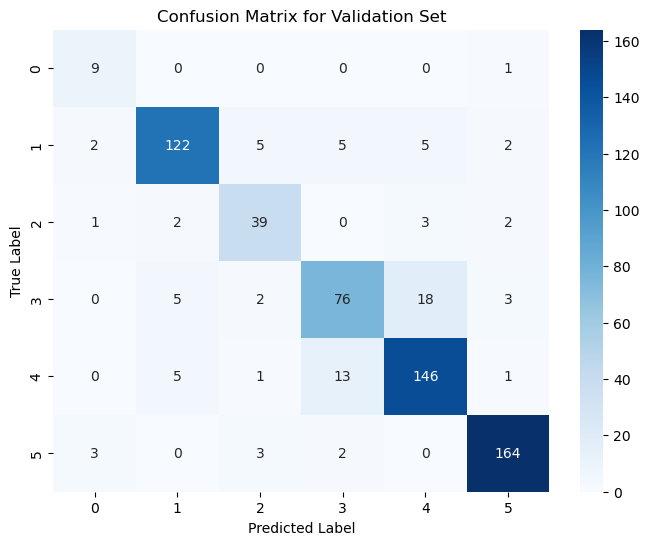

Number of True Class 3 predicted as 4: 18
Number of True Class 4 predicted as 3: 13

Sample Probabilities for True Class 3 predicted as 4:
[0.69968253 0.56831557 0.6578905  0.46800736 0.78767854]

Sample Probabilities for True Class 4 predicted as 3:
[0.45906788 0.8216979  0.4799753  0.59298116 0.53994435]

Summary Statistics for True Class 3 predicted as 4:
Mean Probability Assigned to Class 4: 0.6043
Median Probability Assigned to Class 4: 0.6372
Minimum Probability Assigned to Class 4: 0.4014
Maximum Probability Assigned to Class 4: 0.7914

Summary Statistics for True Class 4 predicted as 3:
Mean Probability Assigned to Class 3: 0.5398
Median Probability Assigned to Class 3: 0.5178
Minimum Probability Assigned to Class 3: 0.3897
Maximum Probability Assigned to Class 3: 0.8217


In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
vit_model = models.vit_b_16(weights=None,image_size=512)  # no pretrained weights
num_features = vit_model.heads[0].in_features
vit_model.heads[0] = nn.Linear(num_features,6)
vit_model.load_state_dict(torch.load("vit_model.pth", map_location=device))
vit_model.eval()# Make sure the model is in evaluation mode

all_preds = []
all_trues = []
all_probs = []  # To store softmax probabilities

with torch.no_grad():
    for img, lb in val_loader:
        img = img.to(device)
        lb = lb.to(device)
        outputs = vit_model(img)  # Raw logits
        probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        
        preds = torch.argmax(probs, dim=1).cpu().numpy()
        labels = lb.cpu().numpy()
        probs_np = probs.cpu().numpy()  # Convert probabilities to numpy array
        
        all_preds.extend(preds)
        all_trues.extend(labels)
        all_probs.extend(probs_np)  # Each entry in all_probs is a list of probabilities for 6 classes

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_trues = np.array(all_trues)
all_probs = np.array(all_probs)  # Shape: (num_samples, 6))

# Calculate confusion matrix
cm = confusion_matrix(all_trues, all_preds)
acc = accuracy_score(all_trues, all_preds)

print("Validation Accuracy:", acc)
print("Confusion Matrix:\n", cm)

# Optionally, you can visualize the confusion matrix:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set')
plt.show()

# Find indices where true label is 3 and predicted label is 4
true_3_pred_4 = np.where((all_trues == 3) & (all_preds == 4))[0]

# Find indices where true label is 4 and predicted label is 3
true_4_pred_3 = np.where((all_trues == 4) & (all_preds == 3))[0]

# Number of such misclassifications
num_true_3_pred_4 = len(true_3_pred_4)
num_true_4_pred_3 = len(true_4_pred_3)

print(f"Number of True Class 3 predicted as 4: {num_true_3_pred_4}")
print(f"Number of True Class 4 predicted as 3: {num_true_4_pred_3}")

# -------------------------------
# Extract Probabilities for Misclassifications
# -------------------------------
# For True class 3 predicted as 4: get probability of class 4
probs_true_3_pred_4 = all_probs[true_3_pred_4, 4]  # Index 4 corresponds to class 4

# For True class 4 predicted as 3: get probability of class 3
probs_true_4_pred_3 = all_probs[true_4_pred_3, 3]  # Index 3 corresponds to class 3

# Display some example probabilities
print("\nSample Probabilities for True Class 3 predicted as 4:")
print(probs_true_3_pred_4[:18])  # Show first 5 probabilities

print("\nSample Probabilities for True Class 4 predicted as 3:")
print(probs_true_4_pred_3[:13])  # Show first 5 probabilities

# -------------------------------
# Analyze the Extracted Probabilities
# -------------------------------
# Compute summary statistics
print("\nSummary Statistics for True Class 3 predicted as 4:")
print(f"Mean Probability Assigned to Class 4: {probs_true_3_pred_4.mean():.4f}")
print(f"Median Probability Assigned to Class 4: {np.median(probs_true_3_pred_4):.4f}")
print(f"Minimum Probability Assigned to Class 4: {probs_true_3_pred_4.min():.4f}")
print(f"Maximum Probability Assigned to Class 4: {probs_true_3_pred_4.max():.4f}")

print("\nSummary Statistics for True Class 4 predicted as 3:")
print(f"Mean Probability Assigned to Class 3: {probs_true_4_pred_3.mean():.4f}")
print(f"Median Probability Assigned to Class 3: {np.median(probs_true_4_pred_3):.4f}")
print(f"Minimum Probability Assigned to Class 3: {probs_true_4_pred_3.min():.4f}")
print(f"Maximum Probability Assigned to Class 3: {probs_true_4_pred_3.max():.4f}")


In [54]:
print("\nSample Probabilities for True Class 3 predicted as 4:")
print(probs_true_3_pred_4[:18])  # Show first 5 probabilities

print("\nSample Probabilities for True Class 4 predicted as 3:")
print(probs_true_4_pred_3[:13])  # Show first 5 probabilities


Sample Probabilities for True Class 3 predicted as 4:
[0.69968253 0.56831557 0.6578905  0.46800736 0.78767854 0.5274203
 0.72548366 0.63057625 0.6494489  0.6661279  0.79143083 0.64391434
 0.46895704 0.69373786 0.55425346 0.41931093 0.40142205 0.52294093]

Sample Probabilities for True Class 4 predicted as 3:
[0.45906788 0.8216979  0.4799753  0.59298116 0.53994435 0.6175307
 0.57264894 0.47209457 0.5177962  0.59453756 0.3896793  0.47065556
 0.48911667]


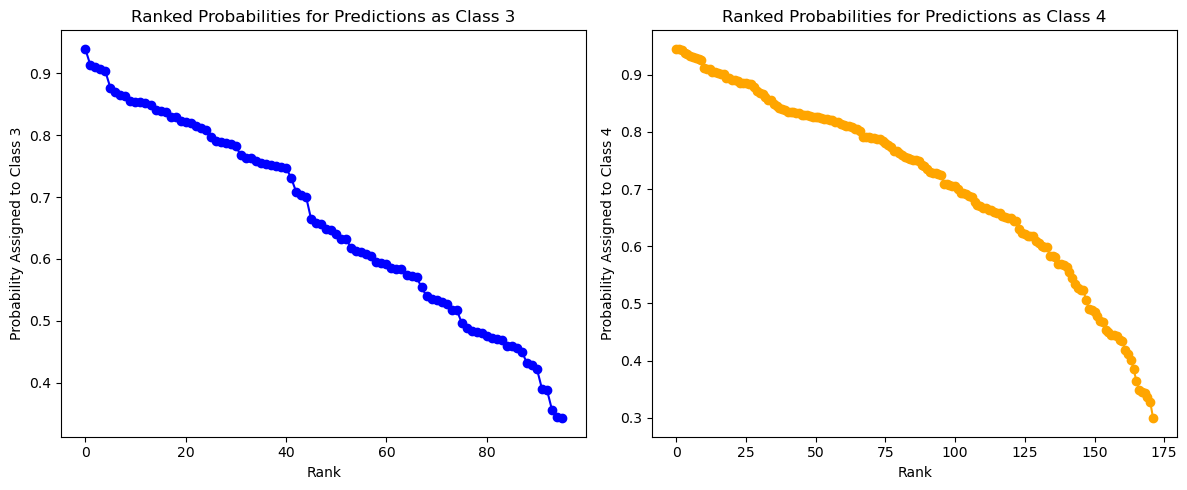

In [57]:
# Identify all predictions classified as 3 and 4
predicted_as_3 = np.where(all_preds == 3)[0]
predicted_as_4 = np.where(all_preds == 4)[0]

# Extract probabilities assigned to the predicted class
probs_pred_3 = all_probs[predicted_as_3, 3]  # Probability assigned to class 3
probs_pred_4 = all_probs[predicted_as_4, 4]  # Probability assigned to class 4

# Sort the probabilities in descending order for ranking
probs_pred_3_sorted = np.sort(probs_pred_3)[::-1]
probs_pred_4_sorted = np.sort(probs_pred_4)[::-1]

# Plot the ranked probabilities
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(probs_pred_3_sorted, marker='o', linestyle='-', color='blue')
plt.xlabel('Rank')
plt.ylabel('Probability Assigned to Class 3')
plt.title('Ranked Probabilities for Predictions as Class 3')

plt.subplot(1, 2, 2)
plt.plot(probs_pred_4_sorted, marker='o', linestyle='-', color='orange')
plt.xlabel('Rank')
plt.ylabel('Probability Assigned to Class 4')
plt.title('Ranked Probabilities for Predictions as Class 4')

plt.tight_layout()
plt.show()

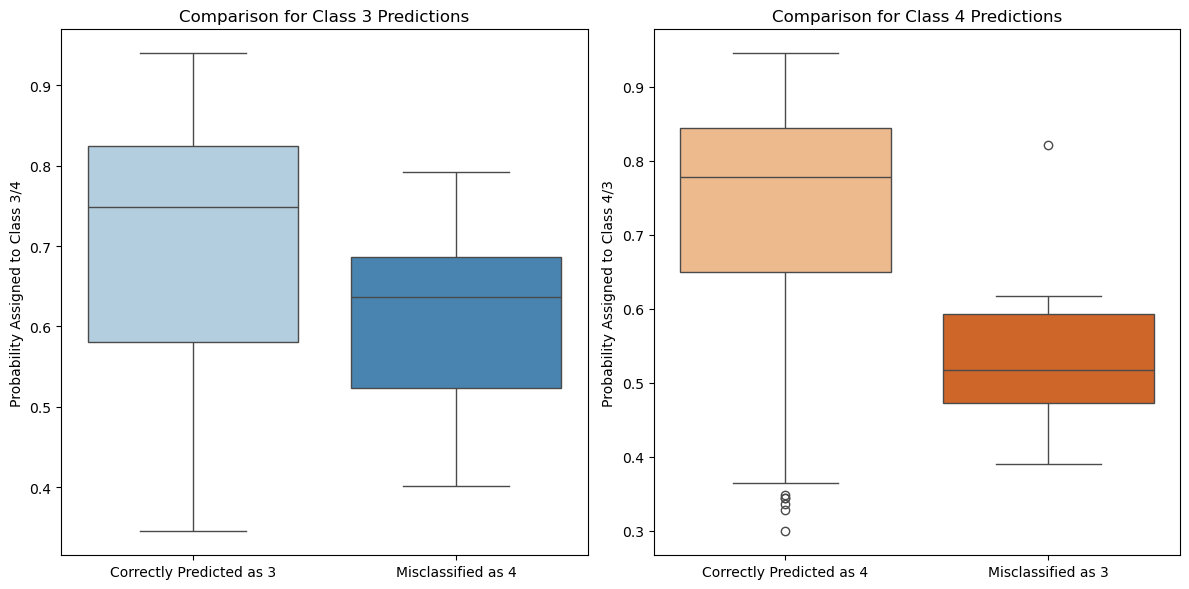

In [59]:
# Correct predictions for class 3 and 4
correct_3 = np.where((all_trues == 3) & (all_preds == 3))[0]
correct_4 = np.where((all_trues == 4) & (all_preds == 4))[0]

# Extract probabilities for correct predictions
probs_correct_3 = all_probs[correct_3, 3]
probs_correct_4 = all_probs[correct_4, 4]

# Extract probabilities for misclassified predictions
probs_misclassified_3_pred_4 = all_probs[true_3_pred_4, 4]
probs_misclassified_4_pred_3 = all_probs[true_4_pred_3, 3]

# Plot boxplots to compare
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.boxplot(data=[probs_correct_3, probs_misclassified_3_pred_4], palette='Blues')
plt.xticks([0,1], ['Correctly Predicted as 3', 'Misclassified as 4'])
plt.ylabel('Probability Assigned to Class 3/4')
plt.title('Comparison for Class 3 Predictions')

plt.subplot(1, 2, 2)
sns.boxplot(data=[probs_correct_4, probs_misclassified_4_pred_3], palette='Oranges')
plt.xticks([0,1], ['Correctly Predicted as 4', 'Misclassified as 3'])
plt.ylabel('Probability Assigned to Class 4/3')
plt.title('Comparison for Class 4 Predictions')

plt.tight_layout()
plt.show()

C:\Users\zhuol\AppData\Local\Temp\ipykernel_19900\2457918883.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load("vit_model.pth", map_l

Initial Performance with Defined Thresholds:
Validation Accuracy: 0.8141
Validation F1-Score (Macro): 0.7748
Confusion Matrix:
 [[  9   0   0   0   0   1]
 [  4 103  12  10  10   2]
 [  0   3  41   0   2   1]
 [  0   2   2  71  26   3]
 [  0   5   6  18 137   0]
 [  4   2   3   1   2 160]]


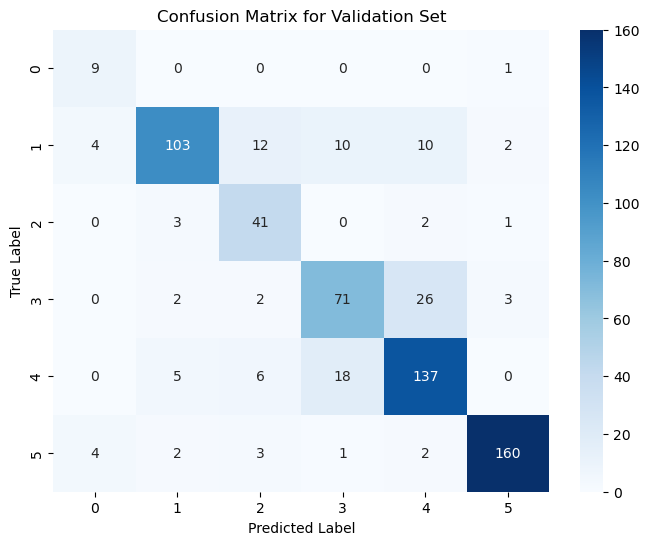

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
from itertools import product

# Define per-class thresholds and grid search ranges
class_thresholds = {
    0: 0.5,
    1: 0.5,
    2: 0.5,
    3: 0.5,
    4: 0.5,
    5: 0.53
}

threshold_grid = {
    0: [0.60, 0.65, 0.70],
    1: [0.45, 0.50, 0.55],
    2: [0.55, 0.60, 0.65],
    3: [0.65, 0.70, 0.75],
    4: [0.45, 0.50, 0.55],
    5: [0.50, 0.53, 0.56]
}

vit_model = models.vit_b_16(weights=None,image_size=512)  # no pretrained weights
num_features = vit_model.heads[0].in_features
vit_model.heads[0] = nn.Linear(num_features,6)
vit_model.load_state_dict(torch.load("vit_model.pth", map_location=device))
vit_model.eval()# Make sure the model is in evaluation mode

test_indices = []
test_top_predictions = []  # Structure: (top_class, top_prob, second_class, second_prob)
all_trues = []

with torch.no_grad():
    for img_batch, lb_batch in val_loader:
        img_batch = img_batch.to(device)
        lb_batch = lb_batch.to(device)
        outputs = vit_model(img_batch)  # Shape: (batch_size, 6)
        probs = F.softmax(outputs, dim=1)  # Shape: (batch_size, 6)

        # Get top 2 predictions
        top2_probs, top2_classes = torch.topk(probs, k=2, dim=1)  # Each of shape: (batch_size, 2)

        top2_probs = top2_probs.cpu().numpy()
        top2_classes = top2_classes.cpu().numpy()
        lb_batch = lb_batch.cpu().numpy()

        for i in range(len(lb_batch)):
            test_indices.append(i)  # Assuming positional indices (0 to len(val_dataset)-1)
            test_top_predictions.append((
                top2_classes[i, 0], top2_probs[i, 0],
                top2_classes[i, 1], top2_probs[i, 1]
            ))
            all_trues.append(lb_batch[i])

# Convert lists to numpy arrays
test_top_predictions = np.array(test_top_predictions)
all_trues = np.array(all_trues)

# -------------------------------
# Define Functions
# -------------------------------
def apply_per_class_thresholds(top_predictions, class_thresholds):
    """
    Apply per-class thresholds to top predictions.

    Parameters:
    - top_predictions: np.array of shape (num_samples, 4) containing (c1, p1, c2, p2)
    - class_thresholds: dict mapping class index to threshold

    Returns:
    - final_preds: list of final predicted classes
    - indices_for_refinement: list of indices where prediction is class 3 or 4
    """
    final_preds = []
    indices_for_refinement = []

    for idx, (c1, p1, c2, p2) in enumerate(top_predictions):
        threshold = class_thresholds.get(c1, 0.5)  # Default threshold if not specified
        if p1 >= threshold:
            final_preds.append(c1)
        else:
            final_preds.append(c2)

        # Identify predictions as 3 or 4 for potential refinement
        if final_preds[-1] in [3, 4]:
            indices_for_refinement.append(idx)

    return final_preds, indices_for_refinement

def evaluate_performance(true_labels, predicted_labels, class_names=None):
    """
    Evaluate and display model performance.

    Parameters:
    - true_labels: np.array of true labels
    - predicted_labels: list or np.array of predicted labels
    - class_names: list of class names (optional)

    Returns:
    - metrics: dict containing accuracy and F1-Score
    """
    cm = confusion_matrix(true_labels, predicted_labels)
    acc = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Validation F1-Score (Macro): {f1:.4f}")
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else range(6),
                yticklabels=class_names if class_names else range(6))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Validation Set')
    plt.show()

    metrics = {
        'accuracy': acc,
        'f1_score': f1,
        'confusion_matrix': cm
    }

    return metrics

# -------------------------------
# Apply Initial Thresholds and Evaluate
# -------------------------------
# Apply initial per-class thresholds
final_predictions, indices_for_refinement = apply_per_class_thresholds(test_top_predictions, class_thresholds)

# Evaluate initial performance
print("Initial Performance with Defined Thresholds:")
metrics_initial = evaluate_performance(all_trues, final_predictions)

1115


C:\Users\zhuol\AppData\Local\Temp\ipykernel_19900\1246159084.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load("resnet_ming_qing.pth", m

Epoch 1/5, Loss: 0.4762, Val Acc: 0.7370
Epoch 2/5, Loss: 0.4427, Val Acc: 0.7074
Epoch 3/5, Loss: 0.4227, Val Acc: 0.7889
Epoch 4/5, Loss: 0.3544, Val Acc: 0.7074
Epoch 5/5, Loss: 0.3075, Val Acc: 0.6630
Binary Classifier Validation Accuracy: 0.662962962962963
Binary Classifier Validation F1: 0.6642810494885966
Confusion Matrix:
 [[87 17]
 [74 92]]


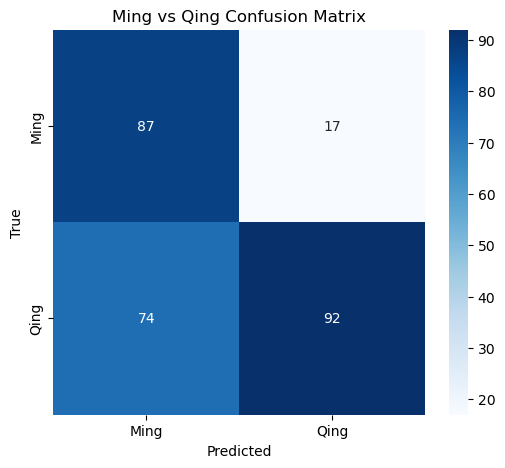

In [16]:
ming_label_name = 3
qing_label_name = 4

def filter_ming_qing(ds, ming_label_name, qing_label_name):
    # We gather indices of ming and qing only
    indices = []
    for i in range(len(ds)):
        _, lb_name = ds[i]
        if lb_name == ming_label_name or lb_name == qing_label_name:
            indices.append(i)
    return Subset(ds, indices)

ming_qing_train = filter_ming_qing(train_dataset_split, ming_label_name, qing_label_name)
ming_qing_val = filter_ming_qing(val_dataset, ming_label_name, qing_label_name)

print(len(ming_qing_train))

# Map them to binary labels: Ming -> 0, Qing -> 1
class BinaryMappingDataset(Dataset):
    def __init__(self, ds, ming_label_name, qing_label_name):
        self.ds = ds
        self.ming_label_name = ming_label_name
        self.qing_label_name = qing_label_name

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        image, lb_name = self.ds[idx]
        new_lb = 0 if lb_name == self.ming_label_name else 1
        return image, new_lb

ming_qing_train_binary = BinaryMappingDataset(ming_qing_train, ming_label_name, qing_label_name)
ming_qing_val_binary = BinaryMappingDataset(ming_qing_val, ming_label_name, qing_label_name)

# ----------------------------------------------------------
# Handle class imbalance with WeightedRandomSampler
# ----------------------------------------------------------
# Compute class weights from the training dataset
labels_list = []
for i in range(len(ming_qing_train_binary)):
    _, lb = ming_qing_train_binary[i]
    labels_list.append(lb)
labels_list = torch.tensor(labels_list, dtype=torch.long)
class_counts = torch.bincount(labels_list)
class_weights = 1.0 / class_counts.float()  # inverse frequency weighting
sample_weights = class_weights[labels_list]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader_binary = DataLoader(ming_qing_train_binary, batch_size=64, sampler=sampler)
val_loader_binary = DataLoader(ming_qing_val_binary, batch_size=16, shuffle=False)

# ----------------------------------------------------------
# Define a ResNet-50 model from scratch (no pretrained weights)
# ----------------------------------------------------------
resnet = models.resnet50(weights=None)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)  # 2 classes: Ming vs Qing

resnet.load_state_dict(torch.load("resnet_ming_qing.pth", map_location=device))

resnet = resnet.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# ----------------------------------------------------------
# Training & Evaluation Functions
# ----------------------------------------------------------
def evaluate(model, loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for img, lb in loader:
            img, lb = img.to(device), lb.to(device)
            out = model(img)
            pred = out.argmax(dim=1).cpu().numpy()
            preds.extend(pred)
            trues.extend(lb.cpu().numpy())
    preds = np.array(preds)
    trues = np.array(trues)
    acc = (preds == trues).mean()
    return acc, preds, trues

# ----------------------------------------------------------
# Train
# ----------------------------------------------------------
epochs = 5
best_acc = 0.0
for epoch in range(epochs):
    resnet.train()
    total_loss = 0
    for img, lb in train_loader_binary:
        img, lb = img.to(device), lb.to(device)
        optimizer.zero_grad()
        logits = resnet(img)
        loss = criterion(logits, lb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    val_acc, val_preds, val_trues = evaluate(resnet, val_loader_binary)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader_binary):.4f}, Val Acc: {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_state = resnet.state_dict()

# Load best weights
resnet.load_state_dict(best_model_state)

# ----------------------------------------------------------
# Evaluate on Validation Set and Display Confusion Matrix
# ----------------------------------------------------------
val_acc, val_preds, val_trues = evaluate(resnet, val_loader_binary)
cm = confusion_matrix(val_trues, val_preds)
acc = accuracy_score(val_trues, val_preds)
f1 = f1_score(val_trues, val_preds, average='weighted')

print("Binary Classifier Validation Accuracy:", acc)
print("Binary Classifier Validation F1:", f1)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ming','Qing'], yticklabels=['Ming','Qing'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ming vs Qing Confusion Matrix')
plt.show()

In [15]:
# Save the entire model state_dict
torch.save(resnet.state_dict(), "resnet_ming_qing.pth")

In [ ]:
resnet = models.resnet50(weights=None)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)  # 2 classes: Ming vs Qing

resnet.load_state_dict(torch.load("resnet_ming_qing.pth", map_location=device))
resnet = resnet.to(device)

# --- Focal Loss Implementation ---
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # can be a float or a tensor of shape [num_classes]
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: (N, C), targets: (N)
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)
        # Gather log_probs corresponding to targets
        log_pt = log_probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        pt = probs.gather(1, targets.unsqueeze(1)).squeeze(1)

        # Compute focal loss
        loss = - ( (1 - pt)**self.gamma ) * log_pt

        if self.alpha is not None:
            # Alpha weighting
            if isinstance(self.alpha, float):
                alpha_t = self.alpha * (targets == 1).float() + (1 - self.alpha) * (targets == 0).float()
            else:
                # If alpha is a tensor/list of per-class weights
                alpha_t = self.alpha[targets]
            loss = alpha_t * loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# Replace criterion with focal loss
criterion = FocalLoss(gamma=2.75, alpha=0.6265)  # Adjust gamma, alpha as needed
optimizer = optim.AdamW(resnet.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

def evaluate(model, loader):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for img, lb in loader:
            img, lb = img.to(device), lb.to(device)
            out = model(img)
            pred = out.argmax(dim=1).cpu().numpy()
            preds.extend(pred)
            trues.extend(lb.cpu().numpy())
    preds = np.array(preds)
    trues = np.array(trues)
    acc = (preds == trues).mean()
    return acc, preds, trues

# Train for another round with Focal Loss
epochs = 10
best_acc = 0.0
best_model_state = None
for epoch in range(epochs):
    resnet.train()
    total_loss = 0
    for img, lb in train_loader_binary:
        img, lb = img.to(device), lb.to(device)
        optimizer.zero_grad()
        logits = resnet(img)
        loss = criterion(logits, lb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    val_acc, val_preds, val_trues = evaluate(resnet, val_loader_binary)
    print(f"[Focal] Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader_binary):.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_state = resnet.state_dict()

# Load best weights from this focal training round
resnet.load_state_dict(best_model_state)

# Evaluate final model with focal training
val_acc, val_preds, val_trues = evaluate(resnet, val_loader_binary)
cm = confusion_matrix(val_trues, val_preds)
acc = accuracy_score(val_trues, val_preds)
f1 = f1_score(val_trues, val_preds, average='weighted')

print("Final Binary Classifier Validation Accuracy:", acc)
print("Final Binary Classifier Validation F1:", f1)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ming','Qing'], yticklabels=['Ming','Qing'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ming vs Qing Confusion Matrix (Focal Loss)')
plt.show()

C:\Users\zhuol\AppData\Local\Temp\ipykernel_19900\1169670706.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load("resnet_ming_qing.pth", ma

[Weighted Focal] Epoch 1/10, Loss: 0.0592, Val Acc: 0.7889
[Weighted Focal] Epoch 2/10, Loss: 0.0530, Val Acc: 0.7556
[Weighted Focal] Epoch 3/10, Loss: 0.0329, Val Acc: 0.7444
[Weighted Focal] Epoch 4/10, Loss: 0.0412, Val Acc: 0.7481


KeyboardInterrupt: 

C:\Users\zhuol\AppData\Local\Temp\ipykernel_19900\3011054789.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet.load_state_dict(torch.load("resnet_ming_qing.pth", ma

Final Binary Classifier Validation Accuracy: 0.774074074074074
Final Binary Classifier Validation F1: 0.7713892163907703
Confusion Matrix:
 [[ 68  36]
 [ 25 141]]


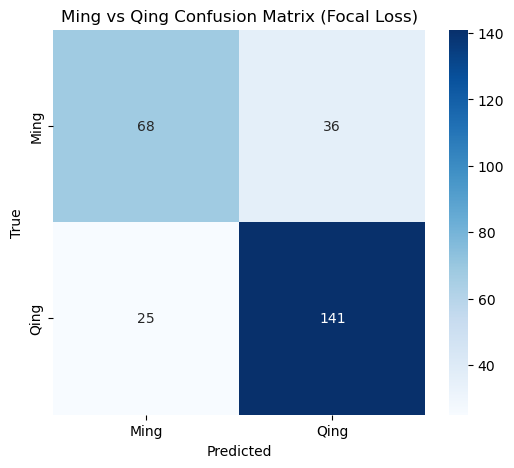

In [92]:
resnet = models.resnet50(weights=None)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)  # 2 classes: Ming vs Qing

resnet.load_state_dict(torch.load("resnet_ming_qing.pth", map_location=device))
resnet = resnet.to(device)

# Evaluate final model with focal training
val_acc, val_preds, val_trues = evaluate(resnet, val_loader_binary)
cm = confusion_matrix(val_trues, val_preds)
acc = accuracy_score(val_trues, val_preds)
f1 = f1_score(val_trues, val_preds, average='weighted')

print("Final Binary Classifier Validation Accuracy:", acc)
print("Final Binary Classifier Validation F1:", f1)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ming','Qing'], yticklabels=['Ming','Qing'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ming vs Qing Confusion Matrix (Focal Loss)')
plt.show()

In [ ]:
# -------------------------------------------
# Inference on Test set
# -------------------------------------------
vit_model = models.vit_b_16(weights=None,image_size=512)  # no pretrained weights
num_features = vit_model.heads[0].in_features
vit_model.heads[0] = nn.Linear(num_features,6)
vit_model.load_state_dict(torch.load("vit_model.pth", map_location=device))

vit_model.eval()
test_preds = []
test_indices = []

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

with torch.no_grad():
    for img, idxs in test_loader:
        img = img.to(device)
        out = vit_model(img)
        pred = out.argmax(dim=1).cpu().numpy().tolist()
        test_preds.extend(pred)
        test_indices.extend(idxs.numpy().tolist())

output_path = "submission.csv"
with open(output_path, "w") as f:
    f.write("idx,predicted_label\n")
    for i, p in zip(test_indices, test_preds):
        f.write(f"{i},{p}\n")

print(f"Submission saved to {output_path}")

In [83]:
# After you've trained your model and have the best weights loaded:
model_path = "resnet_ming_qing.pth"
torch.save(resnet.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to resnet_ming_qing.pth


In [32]:
# Replace 'MyDrive' and 'your-folder' with your actual Drive folders
save_path_final = "vit_model_new.pth"
save_path_binary = "final_binary_model.pth"

torch.save(vit_model.state_dict(), save_path_final)
torch.save(binary_model.state_dict(), save_path_binary)

print("Models saved to local")

NameError: name 'binary_model' is not defined

In [113]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------
# Inference on Test set
# -------------------------------------------
vit_model = models.vit_b_16(weights=None, image_size=512)  # no pretrained weights
num_features = vit_model.heads[0].in_features
vit_model.heads[0] = nn.Linear(num_features, 6)
vit_model.load_state_dict(torch.load("vit_model.pth", map_location=device))
vit_model = vit_model.to(device)
vit_model.eval()

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

threshold = 0.53
threshold_song = 0.45

test_indices = []
test_top_predictions = []
# (top_class, top_class_prob, second_class, second_class_prob)

with torch.no_grad():
    for img, idxs in test_loader:
        img = img.to(device)
        out = vit_model(img)  # shape: (batch, 6)
        probs = F.softmax(out, dim=1)  # shape: (batch, 6)

        # Get top 2 predictions
        top2_values, top2_indices = torch.topk(probs, k=2, dim=1)  
        
        top2_values = top2_values.cpu().numpy()
        top2_indices = top2_indices.cpu().numpy()
        idxs = idxs.cpu().numpy()
        
        for i in range(len(idxs)):
            test_indices.append(idxs[i])
            test_top_predictions.append((top2_indices[i,0], top2_values[i,0],
                                         top2_indices[i,1], top2_values[i,1]))

# Apply threshold logic
final_predictions = []
for (c1, p1, c2, p2) in test_top_predictions:
    if c1 == 5:
        # According to the confusion matrix, the AI and nonAi classifier are prone to overconfident
        if p1 >= threshold:
            # Remain class 5
            final_predictions.append(5)
        else:
            # Assign second-best class
            final_predictions.append(c2)
    elif c1 == 0 or c1 == 2:
        # According to the confusion matrix, Tang, Song, Yuan is easy to mistaken
        if p1 <= threshold_song:
            final_predictions.append(1)
        else:
            final_predictions.append(c1)
    else:
        # Just assign top class
        final_predictions.append(c1)

# Save results to submission file
output_path = "submission.csv"
with open(output_path, "w") as f:
    f.write("idx,predicted_label\n")
    for idx, pred in zip(test_indices, final_predictions):
        f.write(f"{idx},{pred}\n")

print(f"Submission saved to {output_path}")
print(f"Threshold used: {threshold}")

C:\Users\zhuol\AppData\Local\Temp\ipykernel_19900\3538004035.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_model.load_state_dict(torch.load("vit_model.pth", map_l

Submission saved to submission.csv
Threshold used: 0.53


In [ ]:
save_path_binary = "final_binary_model.pth"
torch.save(binary_model.state_dict(), save_path_binary)
print("binary model dowload!")

binary model dowload!
